In [2]:
from selenium import webdriver
import time
from time import sleep
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

merging the initial dataframe with the scraping done for popular dishes... and reviews

In [425]:
df1=pd.read_csv("Bangalore_restaurants.csv")
df2=pd.read_csv('bangalore_restaurants_scraping1.csv')
df3=pd.read_csv('zomato_restaurant_reviews.csv')

In [293]:
df3=pd.read_csv('zomato_restaurant_reviews.csv')

In [426]:
df2.isna().sum()

Unnamed: 0            0
links                 0
popular dishes        4
place is known for    4
dtype: int64

In [427]:
df2[df2.isna().any(axis=1)]

,Unnamed: 0,links,popular dishes,place is known for
19,19,https://www.zomato.com/bangalore/magic-mocktai...,NaN,NaN
37,37,https://www.zomato.com/bangalore/stories-brewe...,NaN,NaN
272,272,https://www.zomato.com/bangalore/barley-broo-1...,NaN,NaN
407,407,https://www.zomato.com/bangalore/toca-brigade-...,NaN,NaN


In [428]:
df2.loc[37,'popular dishes']='Fruit Passion Mocktail, Tandoori Khumb, Strawberry Margarita, Paneer Papdi, Brewed Wheat Beer, Chakna Platter'
df2.loc[37, 'place is known for']='Superb Food and Great Service, Everthing is Perfect, Loved the Ambience, Live Entertainment, Nice Ambience Nice Crowd, Good Bartenders'

In [429]:
df2.fillna('', inplace=True)

Cleaning df2 - some resturants do not have popular dishes or things they are known for. we need to remove the irrelevant information copied

In [430]:
df2.loc[df2['popular dishes'].str.contains('for two people', case=False),'popular dishes']=''
df2.loc[df2['place is known for'].str.contains('exclusive of applicable taxes', case=False),'place is known for']=''
df2.loc[df2['place is known for'].str.contains('for two people', case=False),'place is known for']=''
df2

,Unnamed: 0,links,popular dishes,place is known for
0,0,https://www.zomato.com/bangalore/jamming-goat-...,,
1,1,https://www.zomato.com/bangalore/hydra-club-ki...,,
2,2,https://www.zomato.com/bangalore/scottish-pub-...,"Cheese Cherry Pineapple, Chicken Pakoda, Wine,...","Great Place, Nice Place, Prices, Good Place, S..."
3,3,https://www.zomato.com/bangalore/raahi-st-mark...,"Soya Chaap, Peri Chicken, Wine, Cocktail, Chee...","Innovative Fusion Food, Great Service Good Foo..."
4,4,https://www.zomato.com/bangalore/oney-brewhous...,,
...,...,...,...,...
496,496,https://www.zomato.com/bangalore/the-coffee-br...,,
497,497,https://www.zomato.com/bangalore/gopizza-1-whi...,"Papad, Pizzas, Garlic Bread, Fries, Chicken Wings","Large Servings, Excellent Location, Comforting..."
498,498,https://www.zomato.com/bangalore/spice-it-ibis...,,
499,499,https://www.zomato.com/bangalore/cafe-capricci...,"Ambience, Good Food, Staff, Portion Size, Food...",


In [28]:
# df2.to_excel('bangalore_restaurants_scraping1_cleaned.xlsx')

In [431]:
df2=pd.read_excel('bangalore_restaurants_scraping1_cleaned.xlsx')
df2 = df2.drop(columns=df2.columns[df2.columns.str.contains('Unnamed', case=False)])
df2

,links,popular dishes,place is known for
0,https://www.zomato.com/bangalore/jamming-goat-...,NaN,NaN
1,https://www.zomato.com/bangalore/hydra-club-ki...,NaN,NaN
2,https://www.zomato.com/bangalore/scottish-pub-...,"Cheese Cherry Pineapple, Chicken Pakoda, Wine,...","Great Place, Nice Place, Prices, Good Place, S..."
3,https://www.zomato.com/bangalore/raahi-st-mark...,"Soya Chaap, Peri Chicken, Wine, Cocktail, Chee...","Innovative Fusion Food, Great Service Good Foo..."
4,https://www.zomato.com/bangalore/oney-brewhous...,NaN,NaN
...,...,...,...
496,https://www.zomato.com/bangalore/the-coffee-br...,NaN,NaN
497,https://www.zomato.com/bangalore/gopizza-1-whi...,"Papad, Pizzas, Garlic Bread, Fries, Chicken Wings","Large Servings, Excellent Location, Comforting..."
498,https://www.zomato.com/bangalore/spice-it-ibis...,NaN,NaN
499,https://www.zomato.com/bangalore/cafe-capricci...,NaN,"Ambience, Good Food, Staff, Portion Size, Food..."


In [432]:
df2['place is known for']=df2['place is known for'].str.replace(',','')
df2['popular dishes']=df2['popular dishes'].str.replace(',','')
df2.fillna('', inplace=True)
df2

,links,popular dishes,place is known for
0,https://www.zomato.com/bangalore/jamming-goat-...,,
1,https://www.zomato.com/bangalore/hydra-club-ki...,,
2,https://www.zomato.com/bangalore/scottish-pub-...,Cheese Cherry Pineapple Chicken Pakoda Wine Be...,Great Place Nice Place Prices Good Place Staff...
3,https://www.zomato.com/bangalore/raahi-st-mark...,Soya Chaap Peri Chicken Wine Cocktail Cheeseca...,Innovative Fusion Food Great Service Good Food...
4,https://www.zomato.com/bangalore/oney-brewhous...,,
...,...,...,...
496,https://www.zomato.com/bangalore/the-coffee-br...,,
497,https://www.zomato.com/bangalore/gopizza-1-whi...,Papad Pizzas Garlic Bread Fries Chicken Wings,Large Servings Excellent Location Comforting A...
498,https://www.zomato.com/bangalore/spice-it-ibis...,,
499,https://www.zomato.com/bangalore/cafe-capricci...,,Ambience Good Food Staff Portion Size Food Qua...


In [433]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re


nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def process_sentences(text):
    temp_sent = []
    
    # Tokenize words
    words = nltk.word_tokenize(text)
    
    # Lemmatize each word based on its part of speech
    tags = nltk.pos_tag(words)
    for word, tag in tags:
        if tag.startswith('V'):  # Verbs
            lemmatized = lemmatizer.lemmatize(word, pos='v')
        else:
            lemmatized = lemmatizer.lemmatize(word)
        
        # Remove stop words, non-alphabetic tokens, and numbers
        if lemmatized.lower() not in stop_words and lemmatized.isalpha() and not lemmatized.isdigit():
            temp_sent.append(lemmatized.lower())
    
    # Expand contractions
    contraction_mapping = {"n't": "not", "'m": "am", "'s": "is", "'re": "are", "'ll": "will", "'ve": "have", "'d": "would"}
    full_sentence = ' '.join(temp_sent)
    for contraction, expansion in contraction_mapping.items():
        full_sentence = full_sentence.replace(contraction, expansion)
    
    # Remove extra whitespaces
    full_sentence = re.sub(r'\s+', ' ', full_sentence).strip()
    
    return full_sentence


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [434]:
df2['place_is_known_for_cleaned'] = df2['place is known for'].apply(process_sentences)
df2

,links,popular dishes,place is known for,place_is_known_for_cleaned
0,https://www.zomato.com/bangalore/jamming-goat-...,,,
1,https://www.zomato.com/bangalore/hydra-club-ki...,,,
2,https://www.zomato.com/bangalore/scottish-pub-...,Cheese Cherry Pineapple Chicken Pakoda Wine Be...,Great Place Nice Place Prices Good Place Staff...,great place nice place prices good place staff...
3,https://www.zomato.com/bangalore/raahi-st-mark...,Soya Chaap Peri Chicken Wine Cocktail Cheeseca...,Innovative Fusion Food Great Service Good Food...,innovative fusion food great service good food...
4,https://www.zomato.com/bangalore/oney-brewhous...,,,
...,...,...,...,...
496,https://www.zomato.com/bangalore/the-coffee-br...,,,
497,https://www.zomato.com/bangalore/gopizza-1-whi...,Papad Pizzas Garlic Bread Fries Chicken Wings,Large Servings Excellent Location Comforting A...,large servings excellent location comforting a...
498,https://www.zomato.com/bangalore/spice-it-ibis...,,,
499,https://www.zomato.com/bangalore/cafe-capricci...,,Ambience Good Food Staff Portion Size Food Qua...,ambience good food staff portion size food qua...


In [435]:
from rake_nltk import Rake

In [436]:
df2['known_for_key_words'] = ''
r = Rake()

for index, row in df2.iterrows():
    r.extract_keywords_from_text(row['place_is_known_for_cleaned'])
    key_words_dict_scores = r.get_word_degrees()
    keywords_list = list(key_words_dict_scores.keys())
    df2.at[index, 'known_for_key_words'] = keywords_list
df2

,links,popular dishes,place is known for,place_is_known_for_cleaned,known_for_key_words
0,https://www.zomato.com/bangalore/jamming-goat-...,,,,[]
1,https://www.zomato.com/bangalore/hydra-club-ki...,,,,[]
2,https://www.zomato.com/bangalore/scottish-pub-...,Cheese Cherry Pineapple Chicken Pakoda Wine Be...,Great Place Nice Place Prices Good Place Staff...,great place nice place prices good place staff...,"[great, place, nice, prices, good, staff, serv..."
3,https://www.zomato.com/bangalore/raahi-st-mark...,Soya Chaap Peri Chicken Wine Cocktail Cheeseca...,Innovative Fusion Food Great Service Good Food...,innovative fusion food great service good food...,"[innovative, fusion, food, great, service, goo..."
4,https://www.zomato.com/bangalore/oney-brewhous...,,,,[]
...,...,...,...,...,...
496,https://www.zomato.com/bangalore/the-coffee-br...,,,,[]
497,https://www.zomato.com/bangalore/gopizza-1-whi...,Papad Pizzas Garlic Bread Fries Chicken Wings,Large Servings Excellent Location Comforting A...,large servings excellent location comforting a...,"[large, servings, excellent, location, comfort..."
498,https://www.zomato.com/bangalore/spice-it-ibis...,,,,[]
499,https://www.zomato.com/bangalore/cafe-capricci...,,Ambience Good Food Staff Portion Size Food Qua...,ambience good food staff portion size food qua...,"[ambience, good, food, staff, portion, size, q..."


working on the reviews dataframe

In [438]:
from ast import literal_eval

In [440]:
def convert_to_list(x):
    try:
        return literal_eval(x)
    except ValueError:
        return pd.NA

# Convert strings to python list and dirty data to pandas NA
df3['Reviews_1'] = df3['Reviews'].apply(convert_to_list)
# Convert list of strings to strings
df3['Reviews_1'] = df3['Reviews_1'].apply(lambda x: ', '.join(x))
df3


,links,Reviews,Reviews_1
0,https://www.zomato.com/bangalore/jamming-goat-...,"['', 'Fell in love with their ambience, delici...",", Fell in love with their ambience, delicious ..."
1,https://www.zomato.com/bangalore/hydra-club-ki...,['Wonderful ambience. Great experience with am...,Wonderful ambience. Great experience with amaz...
2,https://www.zomato.com/bangalore/scottish-pub-...,"[""I visited this place last weekend to try the...",I visited this place last weekend to try their...
3,https://www.zomato.com/bangalore/raahi-st-mark...,"['Lovely ambience, amazing cocktail and food!!...","Lovely ambience, amazing cocktail and food!!, ..."
4,https://www.zomato.com/bangalore/oney-brewhous...,['Definitely a place to rock with frinds if yo...,Definitely a place to rock with frinds if you ...
...,...,...,...
496,https://www.zomato.com/bangalore/the-coffee-br...,['The French Fries with Chicken Popcorn was ni...,The French Fries with Chicken Popcorn was nice...
497,https://www.zomato.com/bangalore/gopizza-1-whi...,['It was a nice place for pizza It had nice cu...,It was a nice place for pizza It had nice cust...
498,https://www.zomato.com/bangalore/spice-it-ibis...,"['Good Food', 'Good Food', 'Good Food']","Good Food, Good Food, Good Food"
499,https://www.zomato.com/bangalore/cafe-capricci...,['A Italian fine dining restaurant located in ...,A Italian fine dining restaurant located in rm...


In [441]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [442]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re


nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def remove_emoticons(text):
    # Define emoticon patterns
    emoticon_pattern = r"[:;=8][\'\-]?[\)\(\[\]dDpP/\:\}\{@\|\\]"
    
    # Remove emoticons from text
    text = re.sub(emoticon_pattern, '', text)
    return text


def process_sentences(text):
    temp_sent = []
    
    # Remove emojis
    text = remove_emoticons(text)
    
    # Tokenize words
    words = nltk.word_tokenize(text)
    
    # Lemmatize each word based on its part of speech
    tags = nltk.pos_tag(words)
    for word, tag in tags:
        if tag.startswith('V'):  # Verbs
            lemmatized = lemmatizer.lemmatize(word, pos='v')
        else:
            lemmatized = lemmatizer.lemmatize(word)
        
        # Remove stop words, non-alphabetic tokens, and numbers
        if lemmatized.lower() not in stop_words and lemmatized.isalpha() and not lemmatized.isdigit():
            temp_sent.append(lemmatized.lower())
    
    # Expand contractions
    contraction_mapping = {"n't": "not", "'m": "am", "'s": "is", "'re": "are", "'ll": "will", "'ve": "have", "'d": "would"}
    full_sentence = ' '.join(temp_sent)
    for contraction, expansion in contraction_mapping.items():
        full_sentence = full_sentence.replace(contraction, expansion)
    
    # Remove extra whitespaces
    full_sentence = re.sub(r'\s+', ' ', full_sentence).strip()
    
    return full_sentence


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [443]:
df3['reviews_processed'] = df3['Reviews_1'].apply(process_sentences)

In [444]:
df3['reviews_processed'] = df3['reviews_processed'].str.replace('ambiance','ambience')

In [445]:
df3.head()

,links,Reviews,Reviews_1,reviews_processed
0,https://www.zomato.com/bangalore/jamming-goat-...,"['', 'Fell in love with their ambience, delici...",", Fell in love with their ambience, delicious ...",fell love ambience delicious food cocktail goo...
1,https://www.zomato.com/bangalore/hydra-club-ki...,['Wonderful ambience. Great experience with am...,Wonderful ambience. Great experience with amaz...,wonderful ambience great experience amazing fo...
2,https://www.zomato.com/bangalore/scottish-pub-...,"[""I visited this place last weekend to try the...",I visited this place last weekend to try their...,visit place last weekend try ciro combo oh god...
3,https://www.zomato.com/bangalore/raahi-st-mark...,"['Lovely ambience, amazing cocktail and food!!...","Lovely ambience, amazing cocktail and food!!, ...",lovely ambience amaze cocktail food beautiful ...
4,https://www.zomato.com/bangalore/oney-brewhous...,['Definitely a place to rock with frinds if yo...,Definitely a place to rock with frinds if you ...,definitely place rock frinds look delicious fo...


In [300]:
# # Iterate through each row
# for idx, row in df3.iterrows():
#     # Tokenize the sentence
#     words = re.findall(r'\b\w+\b', row['Reviews_1'])
    
#     # Find the index of the word 'music'
#     try:
#         music_index = words.index('music')
        
#         # Extract the surrounding words
#         start_index = max(0, music_index - 3)
#         end_index = min(len(words), music_index + 4)
#         context = ' '.join(words[start_index:end_index])
        
#         # Store the result in the dictionary
#         result_dict[idx] = context
#     except ValueError:
#         # If 'music' is not found, continue to the next row
#         continue

# # Print the result dictionary
# print(result_dict)

removing additional stop words

In [446]:
from nltk.corpus import stopwords
import string

# Define a function to remove stopwords and punctuation from a text
def preprocess_text(text, additional_stopwords=[]):
    # Tokenize the text
    tokens = text.split()
    
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english') + list(string.punctuation) + additional_stopwords)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Join the tokens back into a string
    preprocessed_text = ' '.join(filtered_tokens)
    
    return preprocessed_text

# Define the additional stop words
additional_stop_words = ['food', 'place', 'chicken', 'one', 'really', 'taste', 'read', 'also',
                         'order','time','dish','well','go','serve','delicious','menu','like','make','drink','u','get','veg','friend','non'
                         'would','pizza','definitely','amaze','bangalore','option','enjoy','starter','give','cheese','come',
                         'overall','main','tasty', 'paneer', 'cuisine', 'every', 'variety', 'special', 'floor', 'loved',
                         'everything', 'even', 'offer', 'look', 'top', 'bar', 'take', 'lot','seating', 'new', 'quality', 'indian', 'table', 'coffee', 'course', 'first', 'highly', 'courteous',
                         'jamming','goat','bengaluru','jp nagar','indiranagar','eat','coming']
#try, visit, friendly, must

# Apply the preprocessing function to each review in the 'reviews processed' column
df3['reviews_processed_SW'] = df3['reviews_processed'].apply(lambda x: preprocess_text(x, additional_stopwords=additional_stop_words))


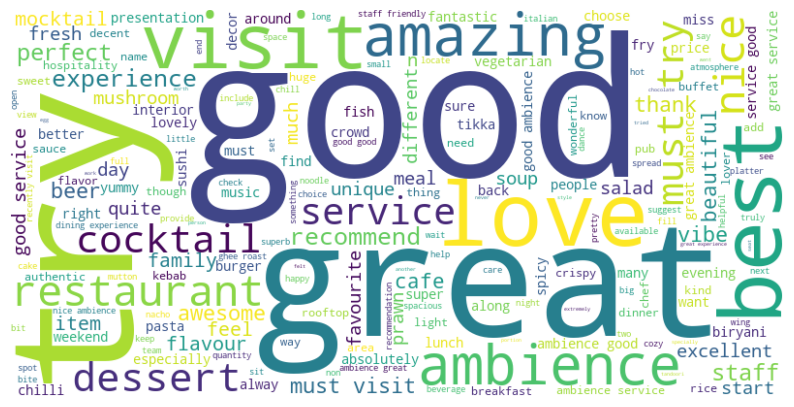

In [447]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all reviews into a single string
all_reviews = ' '.join(df3['reviews_processed_SW'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


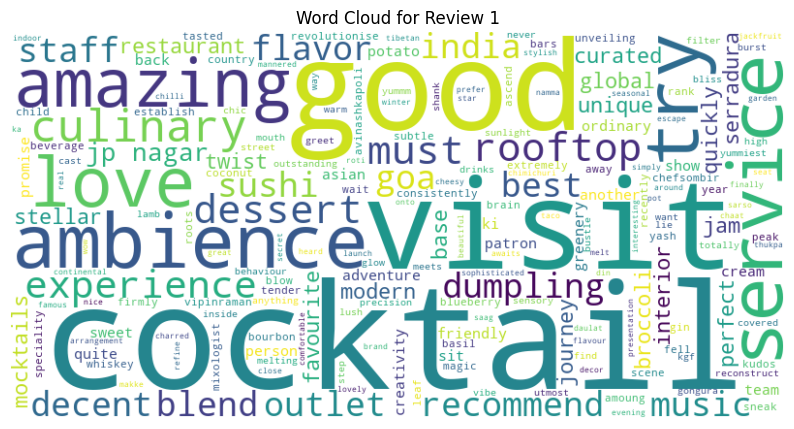

In [448]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Choose the index of the review you want to visualize
review_index = 0  # Change this to the index of the review you want to visualize

# Get the text of the chosen review
review_text = df3.loc[review_index, 'reviews_processed_SW']

# Generate the word cloud for the chosen review
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(review_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Word Cloud for Review {review_index + 1}")
plt.show()


filtering out rows with no reviews

In [449]:
# Filter rows with no reviews
#filtering out rows with no reviews
df3[df3['reviews_processed'].str.len() == 0]
df3_f=df3[df3['reviews_processed'].str.len() != 0]

trying something new

In [450]:
# reviews = []
# for idx in df3.index:
#     text = df3['reviews_processed_SW'][idx]  # Extract the review text from the 'reviews_processed' column
#     reviews.append(text)  # You can append 'date' and 'star_rating' as well if available


In [451]:
# import nltk
# from nltk.tokenize import word_tokenize

# # Tokenize each review in the 'reviews' list
# tokenized_full_reviews = [word_tokenize(review) for review in reviews]


In [452]:
# from collections import Counter
# import pandas as pd

# def get_word_counts(tokenized_sentences):
#     # Flatten the list of tokenized sentences
#     all_words = [word for sentence in tokenized_sentences for word in sentence]
    
#     # Count the occurrences of each word
#     word_counts = Counter(all_words)
    
#     # Convert the Counter object to a DataFrame
#     df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['word_counts'])
    
#     # Sort the DataFrame by word counts in descending order
#     df = df.sort_values(by='word_counts', ascending=False)
    
#     return df


In [453]:
# top_20_count = get_word_counts(tokenized_full_reviews)[0:20]
# print(list(top_20_count.index))

In [253]:
# additional_stop_words=['food', 'place', 'try', 'visit', 'chicken', 'one', 'really', 'taste', 'read', 'also',
#                        'order','time','dish','well','go','serve','delicious','menu','like','make','drink','u','get','veg','friend',
#                        'would','pizza','definitely','amaze','bangalore','friendly','option','enjoy','starter','give','cheese','come',
#                        'overall','main','tasty', 'paneer', 'cuisine', 'every', 'variety', 'special', 'floor', 'loved',
#                        'everything', 'even', 'offer', 'look', 'top', 'bar', 'take', 'lot','seating', 'new', 'quality', 'indian', 'table', 'coffee', 'course', 'first', 'highly', 'courteous']

In [454]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(2, 2))

# Initialize a dictionary to store the top keywords for each restaurant
top_keywords_per_restaurant = {}
double_keyword=[]

# Iterate over each row of the dataframe
for i, row in df3_f.iterrows():
    # Get the concatenated reviews for the current restaurant
    restaurant_reviews = row['reviews_processed_SW']
    
    # Fit and transform the reviews to TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform([restaurant_reviews])

    # Get the feature names (words)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the TF-IDF scores for the restaurant
    tfidf_scores = tfidf_matrix.toarray().flatten()

    # Get the indices of the top N TF-IDF scores
    top_indices = np.argsort(tfidf_scores)[::-1][:20]  # Change 10 to the desired number of top keywords

    # Get the top keywords and their TF-IDF scores
    top_keywords = [(feature_names[idx], tfidf_scores[idx]) for idx in top_indices]    

    # Store the top keywords for the current restaurant
    top_keywords_per_restaurant[i] = top_keywords

# Print the top keywords for each restaurant
for i, keywords in top_keywords_per_restaurant.items():
    print(f"Restaurant {i + 1}: {keywords}")
    keywords_str = ', '.join([keyword[0] for keyword in keywords])
    df3_f.loc[i, 'top_keywords'] = keywords_str

Restaurant 1: [('jp nagar', 0.14621105364857379), ('sweet potato', 0.09747403576571587), ('music decent', 0.09747403576571587), ('good music', 0.09747403576571587), ('best dessert', 0.09747403576571587), ('cocktail good', 0.09747403576571587), ('flavor showcased', 0.04873701788285793), ('fell love', 0.04873701788285793), ('feta stuff', 0.04873701788285793), ('filter covered', 0.04873701788285793), ('finally visit', 0.04873701788285793), ('firmly establish', 0.04873701788285793), ('flavor leave', 0.04873701788285793), ('flavor mixology', 0.04873701788285793), ('flavour asian', 0.04873701788285793), ('favourite consistently', 0.04873701788285793), ('friendly service', 0.04873701788285793), ('friendly welcome', 0.04873701788285793), ('fruit puchkas', 0.04873701788285793), ('garden perfect', 0.04873701788285793)]
Restaurant 2: [('great experience', 0.3359355065735126), ('work surprise', 0.1679677532867563), ('hygiene maintain', 0.1679677532867563), ('ambience great', 0.1679677532867563), (

C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\3599428529.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_f.loc[i, 'top_keywords'] = keywords_str


In [455]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Initialize a dictionary to store the top keywords for each restaurant
top_keywords_per_restaurant = {}
double_keyword=[]

# Iterate over each row of the dataframe
for i, row in df3_f.iterrows():
    # Get the concatenated reviews for the current restaurant
    restaurant_reviews = row['reviews_processed_SW']
    
    # Fit and transform the reviews to TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform([restaurant_reviews])

    # Get the feature names (words)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the TF-IDF scores for the restaurant
    tfidf_scores = tfidf_matrix.toarray().flatten()

    # Get the indices of the top N TF-IDF scores
    top_indices = np.argsort(tfidf_scores)[::-1][:20]  # Change 10 to the desired number of top keywords

    # Get the top keywords and their TF-IDF scores
    top_keywords = [(feature_names[idx], tfidf_scores[idx]) for idx in top_indices]    

    # Store the top keywords for the current restaurant
    top_keywords_per_restaurant[i] = top_keywords

# Print the top keywords for each restaurant
for i, keywords in top_keywords_per_restaurant.items():
    print(f"Restaurant {i + 1}: {keywords}")
    keywords_str = ', '.join([keyword[0] for keyword in keywords])
    df3_f.loc[i, 'top_keywords_single'] = keywords_str

Restaurant 1: [('cocktail', 0.23704991151750873), ('good', 0.23704991151750873), ('visit', 0.23704991151750873), ('try', 0.2031856384435789), ('ambience', 0.2031856384435789), ('service', 0.2031856384435789), ('love', 0.1693213653696491), ('amazing', 0.1693213653696491), ('culinary', 0.1693213653696491), ('rooftop', 0.13545709229571928), ('dessert', 0.13545709229571928), ('experience', 0.13545709229571928), ('cocktails', 0.10159281922178945), ('best', 0.10159281922178945), ('nagar', 0.10159281922178945), ('blend', 0.10159281922178945), ('goa', 0.10159281922178945), ('outlet', 0.10159281922178945), ('flavor', 0.10159281922178945), ('sushi', 0.10159281922178945)]
Restaurant 2: [('nice', 0.5), ('ambience', 0.375), ('good', 0.375), ('cocktail', 0.25), ('experience', 0.25), ('great', 0.25), ('work', 0.125), ('lokho', 0.125), ('crew', 0.125), ('family', 0.125), ('friendly', 0.125), ('hygiene', 0.125), ('maintain', 0.125), ('wonderful', 0.125), ('office', 0.125), ('pleasant', 0.125), ('recomm

C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\240681268.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_f.loc[i, 'top_keywords_single'] = keywords_str


In [456]:
df3_f

,links,Reviews,Reviews_1,reviews_processed,reviews_processed_SW,top_keywords,top_keywords_single
0,https://www.zomato.com/bangalore/jamming-goat-...,"['', 'Fell in love with their ambience, delici...",", Fell in love with their ambience, delicious ...",fell love ambience delicious food cocktail goo...,fell love ambience cocktail good wait visit re...,"jp nagar, sweet potato, music decent, good mus...","cocktail, good, visit, try, ambience, service,..."
1,https://www.zomato.com/bangalore/hydra-club-ki...,['Wonderful ambience. Great experience with am...,Wonderful ambience. Great experience with amaz...,wonderful ambience great experience amazing fo...,wonderful ambience great experience amazing ni...,"great experience, work surprise, hygiene maint...","nice, ambience, good, cocktail, experience, gr..."
2,https://www.zomato.com/bangalore/scottish-pub-...,"[""I visited this place last weekend to try the...",I visited this place last weekend to try their...,visit place last weekend try ciro combo oh god...,visit last weekend try ciro combo oh god die f...,"oldest pub, scottish pub, pub second, noon win...","pub, wine, beer, try, oldest, visit, love, goo..."
3,https://www.zomato.com/bangalore/raahi-st-mark...,"['Lovely ambience, amazing cocktail and food!!...","Lovely ambience, amazing cocktail and food!!, ...",lovely ambience amaze cocktail food beautiful ...,lovely ambience cocktail beautiful fine dining...,"soya chaap, road ambience, nitro sev, puri nit...","love, good, amazing, ambience, try, experience..."
4,https://www.zomato.com/bangalore/oney-brewhous...,['Definitely a place to rock with frinds if yo...,Definitely a place to rock with frinds if you ...,definitely place rock frinds look delicious fo...,rock frinds oney must try sikander sir thank n...,"oney brewhouse, oney apart, set oney, brewery ...","oney, beer, brew, service, experience, try, br..."
...,...,...,...,...,...,...,...
496,https://www.zomato.com/bangalore/the-coffee-br...,['The French Fries with Chicken Popcorn was ni...,The French Fries with Chicken Popcorn was nice...,french fries chicken popcorn coffee brewery ba...,french fries popcorn brewery appear shop chain...,"hot chocolate, board game, friendly helpful, c...","ambience, sandwich, child, setting, people, lo..."
497,https://www.zomato.com/bangalore/gopizza-1-whi...,['It was a nice place for pizza It had nice cu...,It was a nice place for pizza It had nice cust...,nice place pizza nice customer service taste n...,nice nice customer service nice apart station ...,"le delivery, contact le, delivery love, wow hi...","nice, good, love, le, try, gopizza, super, fre..."
498,https://www.zomato.com/bangalore/spice-it-ibis...,"['Good Food', 'Good Food', 'Good Food']","Good Food, Good Food, Good Food",good food good food good food,good good good,good good,good
499,https://www.zomato.com/bangalore/cafe-capricci...,['A Italian fine dining restaurant located in ...,A Italian fine dining restaurant located in rm...,italian fine din restaurant locate rmz infinit...,italian fine din restaurant locate rmz infinit...,"yummy minestrone, decor chance, good panacotta...","best, italian, light, outdoor, dining, service..."


In [457]:
df3_f['trial_rake_keywords'] = ''
r = Rake()

for index, row in df3_f.iterrows():
    r.extract_keywords_from_text(row['reviews_processed_SW'])
    key_words_dict_scores = r.get_word_degrees()
    keywords_list = list(key_words_dict_scores.keys())
    df3_f.at[index, 'trial_rake_keywords'] = keywords_list

C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\498365722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_f['trial_rake_keywords'] = ''


In [458]:
df3_f

,links,Reviews,Reviews_1,reviews_processed,reviews_processed_SW,top_keywords,top_keywords_single,trial_rake_keywords
0,https://www.zomato.com/bangalore/jamming-goat-...,"['', 'Fell in love with their ambience, delici...",", Fell in love with their ambience, delicious ...",fell love ambience delicious food cocktail goo...,fell love ambience cocktail good wait visit re...,"jp nagar, sweet potato, music decent, good mus...","cocktail, good, visit, try, ambience, service,...","[fell, love, ambience, cocktail, good, wait, v..."
1,https://www.zomato.com/bangalore/hydra-club-ki...,['Wonderful ambience. Great experience with am...,Wonderful ambience. Great experience with amaz...,wonderful ambience great experience amazing fo...,wonderful ambience great experience amazing ni...,"great experience, work surprise, hygiene maint...","nice, ambience, good, cocktail, experience, gr...","[wonderful, ambience, great, experience, amazi..."
2,https://www.zomato.com/bangalore/scottish-pub-...,"[""I visited this place last weekend to try the...",I visited this place last weekend to try their...,visit place last weekend try ciro combo oh god...,visit last weekend try ciro combo oh god die f...,"oldest pub, scottish pub, pub second, noon win...","pub, wine, beer, try, oldest, visit, love, goo...","[visit, last, weekend, try, ciro, combo, oh, g..."
3,https://www.zomato.com/bangalore/raahi-st-mark...,"['Lovely ambience, amazing cocktail and food!!...","Lovely ambience, amazing cocktail and food!!, ...",lovely ambience amaze cocktail food beautiful ...,lovely ambience cocktail beautiful fine dining...,"soya chaap, road ambience, nitro sev, puri nit...","love, good, amazing, ambience, try, experience...","[lovely, ambience, cocktail, beautiful, fine, ..."
4,https://www.zomato.com/bangalore/oney-brewhous...,['Definitely a place to rock with frinds if yo...,Definitely a place to rock with frinds if you ...,definitely place rock frinds look delicious fo...,rock frinds oney must try sikander sir thank n...,"oney brewhouse, oney apart, set oney, brewery ...","oney, beer, brew, service, experience, try, br...","[rock, frinds, oney, must, try, sikander, sir,..."
...,...,...,...,...,...,...,...,...
496,https://www.zomato.com/bangalore/the-coffee-br...,['The French Fries with Chicken Popcorn was ni...,The French Fries with Chicken Popcorn was nice...,french fries chicken popcorn coffee brewery ba...,french fries popcorn brewery appear shop chain...,"hot chocolate, board game, friendly helpful, c...","ambience, sandwich, child, setting, people, lo...","[french, fries, popcorn, brewery, appear, shop..."
497,https://www.zomato.com/bangalore/gopizza-1-whi...,['It was a nice place for pizza It had nice cu...,It was a nice place for pizza It had nice cust...,nice place pizza nice customer service taste n...,nice nice customer service nice apart station ...,"le delivery, contact le, delivery love, wow hi...","nice, good, love, le, try, gopizza, super, fre...","[nice, customer, service, apart, station, woul..."
498,https://www.zomato.com/bangalore/spice-it-ibis...,"['Good Food', 'Good Food', 'Good Food']","Good Food, Good Food, Good Food",good food good food good food,good good good,good good,good,[good]
499,https://www.zomato.com/bangalore/cafe-capricci...,['A Italian fine dining restaurant located in ...,A Italian fine dining restaurant located in rm...,italian fine din restaurant locate rmz infinit...,italian fine din restaurant locate rmz infinit...,"yummy minestrone, decor chance, good panacotta...","best, italian, light, outdoor, dining, service...","[italian, fine, din, restaurant, locate, rmz, ..."


In [549]:
import pandas as pd
import spacy
import pytextrank

# Load spaCy model and add PyTextRank to the pipeline
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank")

# Define a function to extract keywords using TextRank
def extract_keywords(text):
    doc = nlp(text)
    return [phrase.text for phrase in doc._.phrases[:10]]

# Assuming df is your DataFrame with a column named 'reviews'
df3_f['keywords_textrank'] = df3_f['reviews_processed_SW'].apply(extract_keywords)

C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\3010625713.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_f['keywords_textrank'] = df3_f['reviews_processed_SW'].apply(extract_keywords)


In [601]:
# Assuming 'text_column' is the name of the column containing the string
df3_f['top_keywords_list'] = df3_f['top_keywords'].str.split(', ')

C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\2050532102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_f['top_keywords_list'] = df3_f['top_keywords'].str.split(', ')


In [689]:
# Function to filter keywords based on the presence of specified keywords
def filter_keywords(keywords_list):
    filtered_keywords = []
    for keyword in keywords_list:
        # Split the keyword by space to get individual words
        words = keyword.split()
        for i, word in enumerate(words):
            # Check if the word is one of the specified keywords
            if word in keywords_to_keep:
                # Add the word before the keyword along with the keyword itself
                if i > 0:
                    filtered_keywords.append(words[i - 1] + ' ' + word)
                else:
                    filtered_keywords.append(word)
                break  # Stop checking for more keywords in this keyword
    return filtered_keywords


In [696]:
# Function to filter keywords based on the presence of specified keywords
def filter_keywords(keywords_list):
    filtered_keywords = []
    # Track the keywords that have been added
    seen_keywords = set()
    for keyword in keywords_list:
        # Split the keyword by space to get individual words
        words = keyword.split()
        # Track the last keyword added
        last_keyword = None
        for word in words:
            # Check if the word is one of the specified keywords
            if word in keywords_to_keep:
                # Construct the keyword phrase
                if last_keyword is not None:
                    key_phrase = last_keyword + ' ' + word
                else:
                    key_phrase = word
                # Check if the keyword phrase has been seen before
                if key_phrase not in seen_keywords:
                    filtered_keywords.append(key_phrase)
                    seen_keywords.add(key_phrase)
                # Update the last keyword
                last_keyword = word
            else:
                # Clear the last keyword if the current word is not a keyword
                last_keyword = None
    return filtered_keywords


In [697]:
df3_f['new_filtered_keywords_textrank'] = df3_f['keywords_textrank'].apply(filter_keywords)

C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\1337750926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_f['new_filtered_keywords_textrank'] = df3_f['keywords_textrank'].apply(filter_keywords)


In [603]:
# Keywords to keep
keywords_to_keep = ['ambience', 'service', 'family', 'friendly', 'music', 'dj', 'entertainment', 'live music', 
                    'hangout', 'fine dining', 'pocket friendly', 'affordable', 'romantic', 'date','party','dance','outdoor','rooftop','pub',
                    'cocktails','cocktail','drinks','club']

# Function to filter keywords based on the presence of specified keywords
def filter_keywords(keywords_list):
    filtered_keywords = []
    for keyword in keywords_list:
        if any(kw in keyword for kw in keywords_to_keep):
            filtered_keywords.append(keyword)
    return filtered_keywords

# Assuming 'keywords' is the column containing the list of keywords
df3_f['filtered_keywords_textrank'] = df3_f['keywords_textrank'].apply(filter_keywords)
df3_f['filtered_top_keywords_list'] = df3_f['top_keywords_list'].apply(filter_keywords)


C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\42167533.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_f['filtered_keywords_textrank'] = df3_f['keywords_textrank'].apply(filter_keywords)
C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\42167533.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_f['filtered_top_keywords_list'] = df3_f['top_keywords_list'].apply(filter_keywords)


In [694]:
df3_f['filtered_keywords_textrank'].loc[80]

['best ambience',
 'romantic cozy vibe ambience',
 'beautiful cozy best part corner whole team ambience',
 'impressed staff good ambience cool thing love',
 'best date night music',
 'good cocktails',
 'great perfect date night hands romantic private cozy amazing vibe sheer curtain decor',
 'amazing ambience low light',
 'month ambience',
 'romantic bit privacy term launch monsoon hand perfect date']

In [881]:
# Filter rows where 'reviews_processed' column contains 'friendly'
filtered_df = df3_f[df3_f['reviews_processed'].str.contains('friendly')]

# Define a function to extract context around the word 'friendly'
def extract_context(review):
    matches = re.findall(r'(\S+)\s+(friendly)\s+(\S+)', review)
    return matches

# Apply the function to extract context for each review
filtered_df['context_around_friendly'] = filtered_df['reviews_processed'].apply(extract_context)

# Show the DataFrame with context around 'friendly'
filtered_df[['reviews_processed', 'context_around_friendly']]

C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\1076631767.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['context_around_friendly'] = filtered_df['reviews_processed'].apply(extract_context)


,reviews_processed,context_around_friendly
0,fell love ambience delicious food cocktail goo...,"[(mannered, friendly, service), (quick, friend..."
1,wonderful ambience great experience amazing fo...,"[(family, friendly, staff), (family, friendly,..."
2,visit place last weekend try ciro combo oh god...,"[(staff, friendly, make), (budget, friendly, p..."
3,lovely ambience amaze cocktail food beautiful ...,"[(really, friendly, put)]"
4,definitely place rock frinds look delicious fo...,"[(dumpling, friendly, service)]"
...,...,...
471,lovely restaurant ambience beautiful hyderabad...,"[(excellent, friendly, environment), (kid, fri..."
473,loved food mehtab help lot recommendation meht...,"[(service, friendly, staff), (courteous, frien..."
474,recently visit royal restaurant authentic raja...,"[(attentive, friendly, clearly)]"
475,golkonda chimney food good like much family re...,"[(nice, friendly, staff), (pocket, friendly, w..."


Combining all the dfs together

In [757]:
duplicate = df1[df1.duplicated(['links'])]
index_names = duplicate.index
print(index_names)

Index([], dtype='int64')


In [461]:
df1.drop(index_names, inplace = True)

In [462]:
duplicate = df2[df2.duplicated(['links'])]
index_names = duplicate.index
print(index_names)

Index([34, 36, 38, 40, 42, 60, 62, 64], dtype='int64')


In [463]:
df2.drop(index_names, inplace=True)

In [464]:
print(df2.shape)
print(df1.shape)

(493, 5)
(493, 7)


In [758]:
duplicate = df3_f[df3_f.duplicated(['links'])]
index_names = duplicate.index
print(index_names)

Index([], dtype='int64')


In [466]:
df3_f.drop(index_names,inplace=True)

C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\2003896636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_f.drop(index_names,inplace=True)


In [467]:
df3_f.shape

(482, 8)

In [759]:
# Reset the index of the DataFrame
df1.reset_index(drop=True, inplace=True)
# Reset the index of the DataFrame
df2.reset_index(drop=True, inplace=True)
# Reset the index of the DataFrame
df3.reset_index(drop=True, inplace=True)
df3_f.reset_index(drop=True, inplace=True)


df_int=df1.merge(df2[['links','place_is_known_for_cleaned','known_for_key_words']], on='links',how='left')
df_int.drop(columns=['Unnamed: 0'], inplace=True)

df_int['links']=df_int['links'].str.replace('/info','')

df_final=pd.merge(df_int,df3_f[['links','top_keywords','reviews_processed_SW','filtered_top_keywords_list','filtered_keywords_textrank']], on='links',how='left')
df_final


,links,names,ratings,price for two,cuisine,Location,place_is_known_for_cleaned,known_for_key_words,top_keywords,reviews_processed_SW,filtered_top_keywords_list,filtered_keywords_textrank
0,https://www.zomato.com/bangalore/jamming-goat-...,Jamming Goat 3.0,4.4,"₹1,500 for two","South Indian, Asian, Thai",Indiranagar,,[],"jp nagar, sweet potato, music decent, good mus...",fell love ambience cocktail good wait visit re...,"[music decent, good music, friendly service, f...","[love ambience cocktail, music decent sit terr..."
1,https://www.zomato.com/bangalore/hydra-club-ki...,Hydra Club & Kitchen,New,"₹1,200 for two",Continental,Koramangala 5th Block,,[],"great experience, work surprise, hygiene maint...",wonderful ambience great experience amazing ni...,"[ambience great, ambience hygiene, ambience ni...",[nice nice wonderful ambience great experience...
2,https://www.zomato.com/bangalore/scottish-pub-...,Scottish Pub,4.3,₹700 for two,Finger Food,St. Marks Road,great place nice place prices good place staff...,"[great, place, nice, prices, good, staff, serv...","oldest pub, scottish pub, pub second, noon win...",visit last weekend try ciro combo oh god die f...,"[oldest pub, scottish pub, pub second, pub ama...","[several pub scottish pub best pub experience,..."
3,https://www.zomato.com/bangalore/raahi-st-mark...,Raahi,4.2,"₹2,000 for two","North Indian, Pasta, Pizza, Desserts, Beverages",St. Marks Road,innovative fusion food great service good food...,"[innovative, fusion, food, great, service, goo...","soya chaap, road ambience, nitro sev, puri nit...",lovely ambience cocktail beautiful fine dining...,"[road ambience, family absolutely, family grea...","[worthy amazing good hangout, awesome clean go..."
4,https://www.zomato.com/bangalore/oney-brewhous...,Oney Brewhouse,New,"₹1,500 for two","American, Continental, Italian, South Indian, ...",Cunningham Road,,[],"oney brewhouse, oney apart, set oney, brewery ...",rock frinds oney must try sikander sir thank n...,[],[experience visit service amazing suggestions ...
...,...,...,...,...,...,...,...,...,...,...,...,...
488,https://www.zomato.com/bangalore/the-coffee-br...,The Coffee Brewery,3.9,₹800 for two,"Cafe, Coffee, Sandwich, Fast Food, Desserts, T...",Koramangala 4th Block,,[],"hot chocolate, board game, friendly helpful, c...",french fries popcorn brewery appear shop chain...,"[friendly helpful, cozy ambience, customer ser...",[bread soft crunchy love nice sandwich hot cho...
489,https://www.zomato.com/bangalore/gopizza-1-whi...,GOPIZZA,4.0,₹500 for two,"Pizza, Fast Food","Phoenix Marketcity Bangalore, Whitefield",large servings excellent location comforting a...,"[large, servings, excellent, location, comfort...","le delivery, contact le, delivery love, wow hi...",nice nice customer service nice apart station ...,[],"[nice nice customer service, awesome contact l..."
490,https://www.zomato.com/bangalore/spice-it-ibis...,Spice It - Ibis Hotel,3.7,"₹1,800 for two","North Indian, Chinese, Italian, Continental, P...",Hebbal,,[],good good,good good good,[],[]
491,https://www.zomato.com/bangalore/cafe-capricci...,Cafe Capriccio,4.1,₹800 for two,"Italian, Pasta, Pizza, Salad","RMZ Infinity, Old Madras Road",ambience good food staff portion size food qua...,"[ambience, good, food, staff, portion, size, q...","yummy minestrone, decor chance, good panacotta...",italian fine din restaurant locate rmz infinit...,"[good outdoor, family dining]",[italian fine din restaurant locate rmz infini...


In [760]:
# Assuming 'column_name' is the name of the column containing the list values
# Assuming 'column_name' is the name of the column containing the list values
df_final['filtered_top_keywords_list'] = df_final['filtered_top_keywords_list'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)


working with top keywords again

In [761]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define the process_sentences function
def process_sentences(text):
    temp_sent = []
    consecutive_adjectives = []
    
    # Tokenize words
    words = word_tokenize(text)
    
    # Get part-of-speech tags for words
    tags = pos_tag(words)
    
    # Iterate through words and tags
    for word, tag in tags:
        # Lemmatize each word based on its part of speech
        if tag.startswith('V'):  # Verbs
            lemmatized = lemmatizer.lemmatize(word, pos='v')
        else:
            lemmatized = lemmatizer.lemmatize(word)
        
        # Check if the current word is an adjective
        if tag == 'JJ':  # Adjectives
            # Check if the adjective is in the exception list
            if lemmatized.lower() in ['fine', 'good','live'] :
            # or (lemmatized.lower() == 'live' and temp_sent and temp_sent[-1] in ['music', 'band', 'entertainment']):
                consecutive_adjectives.append(lemmatized.lower())
            else:
                # If not in exception list, skip the adjective
                continue
        else:
            # If there were consecutive adjectives, append them together
            if consecutive_adjectives:
                temp_sent.append(' '.join(consecutive_adjectives))
                consecutive_adjectives = []
            # Append the current word to the list
            temp_sent.append(lemmatized.lower())
    
    # If there were remaining consecutive adjectives, append them together
    if consecutive_adjectives:
        temp_sent.append(' '.join(consecutive_adjectives))
    
    # Expand contractions
    contraction_mapping = {"n't": "not", "'m": "am", "'s": "is", "'re": "are", "'ll": "will", "'ve": "have", "'d": "would"}
    full_sentence = ' '.join(temp_sent)
    for contraction, expansion in contraction_mapping.items():
        full_sentence = full_sentence.replace(contraction, expansion)
    
    # Remove extra whitespaces
    full_sentence = re.sub(r'\s+', ' ', full_sentence).strip()
    
    return full_sentence


In [762]:
df_final['place_is_known_for_double_cleaned'] = df_final['place_is_known_for_cleaned'].apply(process_sentences)

In [763]:
def remove_duplicates(text):
    # Split the text into words
    words = text.split()
    # Initialize an empty list to store unique words while preserving order
    unique_words = []
    # Iterate through each word in the list
    for word in words:
        # Append the word to the list only if it's not already present
        if word not in unique_words:
            unique_words.append(word)
    # Join the unique words back into a single string
    unique_text = ' '.join(unique_words)
    return unique_text

# Apply the function to the column containing duplicate words
df_final['place_is_known_for_triple_cleaned'] = df_final['place_is_known_for_double_cleaned'].apply(remove_duplicates)

In [764]:
df_final.drop(columns='place_is_known_for_double_cleaned',inplace=True)

In [765]:
print(df_final['place_is_known_for_cleaned'].loc[140])
print(df_final['filtered_top_keywords_list'].loc[140])

portion size food quality value money packaging
eco friendly, great service


In [766]:
df_final['final_reviews']=df_final['place_is_known_for_cleaned']+' ' + df_final['filtered_top_keywords_list'].str.replace(',','')
df_final['final_reviews'].loc[2]

'great place nice place prices good place staff service oldest pub scottish pub pub second pub amazing friendly staff friendly feel friendly pub fresh drinks'

In [755]:
# Filter for rows where 'final reviews' is NaN and 'place is known for cleaned' is not null
condition = df_final['final_reviews'].isna() & df_final['place_is_known_for_cleaned']!=''

# Assign values where the condition is met
df_final.loc[condition, 'final_reviews'] = df_final.loc[condition, 'place_is_known_for_cleaned']

In [776]:
df_final.loc[(df_final['final_reviews'].isna()) & (df_final['place_is_known_for_cleaned']),'final_reviews']=df_final['place_is_known_for_cleaned']
        #  & df_final['place_is_known_for_cleaned']!='']

In [780]:
df_final=df_final.dropna(subset=['final_reviews'])

In [782]:
df_final.reset_index(drop=True, inplace=True)

In [783]:
df_final

,links,names,ratings,price for two,cuisine,Location,place_is_known_for_cleaned,known_for_key_words,top_keywords,reviews_processed_SW,filtered_top_keywords_list,filtered_keywords_textrank,place_is_known_for_triple_cleaned,final_reviews
0,https://www.zomato.com/bangalore/jamming-goat-...,Jamming Goat 3.0,4.4,"₹1,500 for two","South Indian, Asian, Thai",Indiranagar,,[],"jp nagar, sweet potato, music decent, good mus...",fell love ambience cocktail good wait visit re...,"music decent, good music, friendly service, fr...","[love ambience cocktail, music decent sit terr...",,music decent good music friendly service frie...
1,https://www.zomato.com/bangalore/hydra-club-ki...,Hydra Club & Kitchen,New,"₹1,200 for two",Continental,Koramangala 5th Block,,[],"great experience, work surprise, hygiene maint...",wonderful ambience great experience amazing ni...,"ambience great, ambience hygiene, ambience nic...",[nice nice wonderful ambience great experience...,,ambience great ambience hygiene ambience nice...
2,https://www.zomato.com/bangalore/scottish-pub-...,Scottish Pub,4.3,₹700 for two,Finger Food,St. Marks Road,great place nice place prices good place staff...,"[great, place, nice, prices, good, staff, serv...","oldest pub, scottish pub, pub second, noon win...",visit last weekend try ciro combo oh god die f...,"oldest pub, scottish pub, pub second, pub amaz...","[several pub scottish pub best pub experience,...",place price good staff service,great place nice place prices good place staff...
3,https://www.zomato.com/bangalore/raahi-st-mark...,Raahi,4.2,"₹2,000 for two","North Indian, Pasta, Pizza, Desserts, Beverages",St. Marks Road,innovative fusion food great service good food...,"[innovative, fusion, food, great, service, goo...","soya chaap, road ambience, nitro sev, puri nit...",lovely ambience cocktail beautiful fine dining...,"road ambience, family absolutely, family great...","[worthy amazing good hangout, awesome clean go...",fusion food service good highly recommend expe...,innovative fusion food great service good food...
4,https://www.zomato.com/bangalore/oney-brewhous...,Oney Brewhouse,New,"₹1,500 for two","American, Continental, Italian, South Indian, ...",Cunningham Road,,[],"oney brewhouse, oney apart, set oney, brewery ...",rock frinds oney must try sikander sir thank n...,,[experience visit service amazing suggestions ...,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,https://www.zomato.com/bangalore/the-coffee-br...,The Coffee Brewery,3.9,₹800 for two,"Cafe, Coffee, Sandwich, Fast Food, Desserts, T...",Koramangala 4th Block,,[],"hot chocolate, board game, friendly helpful, c...",french fries popcorn brewery appear shop chain...,"friendly helpful, cozy ambience, customer serv...",[bread soft crunchy love nice sandwich hot cho...,,friendly helpful cozy ambience customer servi...
483,https://www.zomato.com/bangalore/gopizza-1-whi...,GOPIZZA,4.0,₹500 for two,"Pizza, Fast Food","Phoenix Marketcity Bangalore, Whitefield",large servings excellent location comforting a...,"[large, servings, excellent, location, comfort...","le delivery, contact le, delivery love, wow hi...",nice nice customer service nice apart station ...,,"[nice nice customer service, awesome contact l...",serving location comfort atmosphere place fami...,large servings excellent location comforting a...
484,https://www.zomato.com/bangalore/spice-it-ibis...,Spice It - Ibis Hotel,3.7,"₹1,800 for two","North Indian, Chinese, Italian, Continental, P...",Hebbal,,[],good good,good good good,,[],,
485,https://www.zomato.com/bangalore/cafe-capricci...,Cafe Capriccio,4.1,₹800 for two,"Italian, Pasta, Pizza, Salad","RMZ Infinity, Old Madras Road",ambience good food staff portion size food qua...,"[ambience, good, food, staff, portion, size, q...","yummy minestrone, decor chance, good panacotta...",italian fine din restaurant locate rmz infinit...,"good outdoor, family dining",[italian fine din restaurant locate rmz infini...,ambience good food s

In [856]:
df_final['final_reviews']=df_final['final_reviews'].str.replace('yummmmm','yummy')
df_final['final_reviews']=df_final['final_reviews'].str.replace('zomota','zomato')
df_final['final_reviews']=df_final['final_reviews'].str.replace('wonderfully','wonderful')
df_final['final_reviews']=df_final['final_reviews'].str.replace('ambiance','ambience')

C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\4294933144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['final_reviews']=df_final['final_reviews'].str.replace('yummmmm','yummy')
C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\4294933144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['final_reviews']=df_final['final_reviews'].str.replace('zomota','zomato')
C:\Users\sunil\AppData\Local\Temp\ipykernel_41656\4294933144.py:3: SettingWithCopyWarning: 
A value is trying to be set 

Creating tfidf vector on location, cuisine and reviews

In [807]:
final_df=df_final.copy()

In [808]:
final_df['area']=''
final_df.loc[final_df['Location'].str.contains('Koramangala', case=False),'area']='Koramangala'
final_df.loc[final_df['Location'].str.contains('Race Course Road', case=False),'area']='Race Course Road'
final_df.loc[final_df['Location'].str.contains('Goldfinch', case=False),'area']='Race Course Road'
final_df.loc[final_df['Location'].str.contains('Sankey Road', case=False),'area']='Race Course Road'
final_df.loc[final_df['Location'].str.contains('Old Madras Road', case=False),'area']='Old Madras Road'
final_df.loc[final_df['Location'].str.contains('Whitefield', case=False),'area']='Whitefield'
final_df.loc[final_df['Location'].str.contains('Craftworks', case=False),'area']='Whitefield'
final_df.loc[final_df['Location'].str.contains('Indiranagar', case=False),'area']='Indiranagar'
final_df.loc[final_df['Location'].str.contains('Brookefield', case=False),'area']='Brookefield'
final_df.loc[final_df['Location'].str.contains('Kanakapura Road', case=False),'area']='Kanakapura Road'
final_df.loc[final_df['Location'].str.contains('JP Nagar', case=False),'area']='JP Nagar'
final_df.loc[final_df['Location'].str.contains('Jayanagar', case=False),'area']='Jayanagar'
final_df.loc[final_df['Location'].str.contains('HSR', case=False),'area']='HSR'
final_df.loc[final_df['Location'].str.contains('Sarjapur', case=False),'area']='Sarjapur'
final_df.loc[final_df['Location'].str.contains('MG Road', case=False),'area']='MG Road'
final_df.loc[final_df['Location'].str.contains('Church Street', case=False),'area']='Church Street'
final_df.loc[final_df['Location'].str.contains('Cunningham Road', case=False),'area']='Cunningham Road'
final_df.loc[final_df['Location'].str.contains('St. Marks Road', case=False),'area']='St. Marks Road'
final_df.loc[final_df['Location'].str.contains('Hebbal', case=False),'area']='Hebbal'
final_df.loc[final_df['Location'].str.contains('Brigade Road', case=False),'area']='Brigade Road'
final_df.loc[final_df['Location'].str.contains('Richmond Road', case=False),'area']='Richmond Road'
final_df.loc[final_df['Location'].str.contains('Lavelle Road', case=False),'area']='Lavelle Road'
final_df.loc[final_df['Location'].str.contains('Marathahalli', case=False),'area']='Marathahalli'
final_df.loc[final_df['Location'].str.contains('Ulsoor', case=False),'area']='Ulsoor'
final_df.loc[final_df['Location'].str.contains('BTM', case=False),'area']='BTM'
final_df.loc[final_df['Location'].str.contains('Kalyan Nagar', case=False),'area']='Kalyan Nagar'
final_df.loc[final_df['Location'].str.contains('Bannerghatta Road', case=False),'area']='Bannerghatta'
final_df.loc[final_df['Location'].str.contains('Vasanth Nagar', case=False),'area']='Vasanth Nagar'
final_df.loc[final_df['Location'].str.contains('New BEL Road', case=False),'area']='New BEL Road'
final_df.loc[final_df['Location'].str.contains('Garuda Mall', case=False),'area']='Ashok Nagar'
final_df.loc[final_df['Location'].str.contains('Forum Rex Walk', case=False),'area']='Ashok Nagar'
final_df.loc[final_df['Location'].str.contains('UB City', case=False),'area']='Ashok Nagar'
final_df.loc[final_df['Location'].str.contains('Shanti Nagar', case=False),'area']='Ashok Nagar'
final_df.loc[final_df['Location'].str.contains('The Chancery Pavilion', case=False),'area']='Ashok Nagar'
final_df.loc[final_df['Location'].str.contains('Barton Centre', case=False),'area']='Ashok Nagar'
final_df.loc[final_df['Location'].str.contains('The Ritz-Carlton', case=False),'area']='Ashok Nagar'
final_df.loc[final_df['Location'].str.contains('1 Sobha', case=False),'area']='Ashok Nagar'
final_df.loc[final_df['Location'].str.contains('Richmond Town', case=False),'area']='Ashok Nagar'
final_df.loc[final_df['Location'].str.contains('Old Airport Road', case=False),'area']='Old Airport Road'
final_df.loc[final_df['Location'].str.contains('Basavanagudi', case=False),'area']='Basavanagudi'
final_df.loc[final_df['Location'].str.contains('Electronic City', case=False),'area']='Electronic City'
final_df.loc[final_df['Location'].str.contains('Hennur', case=False),'area']='Hennur'
final_df.loc[final_df['Location'].str.contains('Hosur Road', case=False),'area']='Hosur Road'
final_df.loc[final_df['Location'].str.contains('Bommanahalli', case=False),'area']='Hosur Road'
final_df.loc[final_df['Location'].str.contains('Bellandur', case=False),'area']='Bellandur'
final_df.loc[final_df['Location'].str.contains('Yelahanka', case=False),'area']='Yelahanka'
final_df.loc[final_df['Location'].str.contains('Brigade Gateway', case=False),'area']='Malleshwaram'
final_df.loc[final_df['Location'].str.contains('Malleshwaram', case=False),'area']='Malleshwaram'
final_df.loc[final_df['Location'].str.contains('Rajajinagar', case=False),'area']='Malleshwaram'
final_df.loc[final_df['Location'].str.contains('Lulu', case=False),'area']='Malleshwaram'
final_df.loc[final_df['Location'].str.contains('World Trade Center', case=False),'area']='Malleshwaram'
final_df.loc[final_df['Location'].str.contains('Domlur', case=False),'area']='Domlur'
final_df.loc[final_df['Location'].str.contains('Kadubeesanahalli', case=False),'area']='Marathahalli'
final_df.loc[final_df['Location'].str.contains('Hebbal', case=False),'area']='Hebbal'
final_df.loc[final_df['Location'].str.contains('RMZ Azure', case=False),'area']='Hebbal'
final_df.loc[final_df['Location'].str.contains('Hotel Country Inn', case=False),'area']='Hebbal'
final_df.loc[final_df['Location'].str.contains('Livin Hub Hotel', case=False),'area']='Marathahalli'
final_df.loc[final_df['Location'].str.contains('Sahakara Nagar', case=False),'area']='Sahakara Nagar'
final_df.loc[final_df['Location'].str.contains('Rajarajeshwari Nagar', case=False),'area']='Rajarajeshwari Nagar'
final_df.loc[final_df['Location'].str.contains('Nagawara', case=False),'area']='Nagawara'
final_df.loc[final_df['Location'].str.contains('Manyata', case=False),'area']='Nagawara'
final_df.loc[final_df['Location'].str.contains('Bhartiya', case=False),'area']='Bhartiya City'
final_df.loc[final_df['Location'].str.contains('Nagarbhavi', case=False),'area']='Nagarbhavi'	
final_df.loc[final_df['Location'].str.contains('Kanakapura', case=False),'area']='Kanakapura'


final_df[final_df['Location'].str.contains('airport', case=False)]
# final_df

,links,names,ratings,price for two,cuisine,Location,place_is_known_for_cleaned,known_for_key_words,top_keywords,reviews_processed_SW,filtered_top_keywords_list,filtered_keywords_textrank,place_is_known_for_triple_cleaned,final_reviews,area
19,https://www.zomato.com/bangalore/koko-airport-...,KOKO,4.4,"₹3,500 for two","Asian, Sushi, Desserts, Chinese, Beverages",Old Airport Road,,[],"service notch, great service, prawn tempura, y...",recently visit koko hear rave review disappoin...,"service notch, great service, experience ambie...","[visit best experience ambience service, mr ra...",,service notch great service experience ambien...,Old Airport Road
88,https://www.zomato.com/bangalore/gawky-goose-a...,Gawky Goose,4.4,"₹2,200 for two","Italian, Biryani, North Indian, Fast Food, Sea...",Old Airport Road,romantic pet friendly music ambience served qu...,"[romantic, pet, friendly, music, ambience, ser...","gawky goose, case fantastic, indoor outdoor, c...",gawky goose beautiful catchup office mate belo...,"indoor outdoor, experience pub",[good nice loveliest experience club chef bart...,pet music ambience serve quickly concept outdoor,romantic pet friendly music ambience served qu...,Old Airport Road
204,https://www.zomato.com/bangalore/jamavar-the-l...,Jamavar - The Leela Palace,4.3,"₹5,000 for two","North Indian, South Indian","The Leela Palace, Old Airport Road",classy place luxury open area quality food ven...,"[classy, place, luxury, open, area, quality, f...","service staff, murgh alamgir, ambience beautif...",breathtaking interior palace restaurant great ...,"service staff, ambience beautiful, nice servic...","[service ambience, nice ambience, exquisite la...",place luxury area quality food venue recommend...,classy place luxury open area quality food ven...,Old Airport Road


In [809]:
final_df=final_df[final_df['area']!='']
final_df

,links,names,ratings,price for two,cuisine,Location,place_is_known_for_cleaned,known_for_key_words,top_keywords,reviews_processed_SW,filtered_top_keywords_list,filtered_keywords_textrank,place_is_known_for_triple_cleaned,final_reviews,area
0,https://www.zomato.com/bangalore/jamming-goat-...,Jamming Goat 3.0,4.4,"₹1,500 for two","South Indian, Asian, Thai",Indiranagar,,[],"jp nagar, sweet potato, music decent, good mus...",fell love ambience cocktail good wait visit re...,"music decent, good music, friendly service, fr...","[love ambience cocktail, music decent sit terr...",,music decent good music friendly service frie...,Indiranagar
1,https://www.zomato.com/bangalore/hydra-club-ki...,Hydra Club & Kitchen,New,"₹1,200 for two",Continental,Koramangala 5th Block,,[],"great experience, work surprise, hygiene maint...",wonderful ambience great experience amazing ni...,"ambience great, ambience hygiene, ambience nic...",[nice nice wonderful ambience great experience...,,ambience great ambience hygiene ambience nice...,Koramangala
2,https://www.zomato.com/bangalore/scottish-pub-...,Scottish Pub,4.3,₹700 for two,Finger Food,St. Marks Road,great place nice place prices good place staff...,"[great, place, nice, prices, good, staff, serv...","oldest pub, scottish pub, pub second, noon win...",visit last weekend try ciro combo oh god die f...,"oldest pub, scottish pub, pub second, pub amaz...","[several pub scottish pub best pub experience,...",place price good staff service,great place nice place prices good place staff...,St. Marks Road
3,https://www.zomato.com/bangalore/raahi-st-mark...,Raahi,4.2,"₹2,000 for two","North Indian, Pasta, Pizza, Desserts, Beverages",St. Marks Road,innovative fusion food great service good food...,"[innovative, fusion, food, great, service, goo...","soya chaap, road ambience, nitro sev, puri nit...",lovely ambience cocktail beautiful fine dining...,"road ambience, family absolutely, family great...","[worthy amazing good hangout, awesome clean go...",fusion food service good highly recommend expe...,innovative fusion food great service good food...,St. Marks Road
4,https://www.zomato.com/bangalore/oney-brewhous...,Oney Brewhouse,New,"₹1,500 for two","American, Continental, Italian, South Indian, ...",Cunningham Road,,[],"oney brewhouse, oney apart, set oney, brewery ...",rock frinds oney must try sikander sir thank n...,,[experience visit service amazing suggestions ...,,,Cunningham Road
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,https://www.zomato.com/bangalore/the-coffee-br...,The Coffee Brewery,3.9,₹800 for two,"Cafe, Coffee, Sandwich, Fast Food, Desserts, T...",Koramangala 4th Block,,[],"hot chocolate, board game, friendly helpful, c...",french fries popcorn brewery appear shop chain...,"friendly helpful, cozy ambience, customer serv...",[bread soft crunchy love nice sandwich hot cho...,,friendly helpful cozy ambience customer servi...,Koramangala
483,https://www.zomato.com/bangalore/gopizza-1-whi...,GOPIZZA,4.0,₹500 for two,"Pizza, Fast Food","Phoenix Marketcity Bangalore, Whitefield",large servings excellent location comforting a...,"[large, servings, excellent, location, comfort...","le delivery, contact le, delivery love, wow hi...",nice nice customer service nice apart station ...,,"[nice nice customer service, awesome contact l...",serving location comfort atmosphere place fami...,large servings excellent location comforting a...,Whitefield
484,https://www.zomato.com/bangalore/spice-it-ibis...,Spice It - Ibis Hotel,3.7,"₹1,800 for two","North Indian, Chinese, Italian, Continental, P...",Hebbal,,[],good good,good good good,,[],,,Hebbal
485,https://www.zomato.com/bangalore/cafe-capricci...,Cafe Capriccio,4.1,₹800 for two,"Italian, Pasta, Pizza, Salad","RMZ Infinity, Old Madras Road",ambience good food staff portion size food qua...,"[ambience, good, food, staff, portion, size, q...","yummy minestrone, decor chance, good panacotta...",italian fine din restaurant locate rmz in

In [810]:
# Create a new column containing lists of cuisine values
# final_df['cuisine_list'] = final_df['cuisine'].str.lower().apply(lambda x: x.split(', '))
final_df['area_list']=final_df['area']
final_df['cuisine_list']=final_df['cuisine']
final_df['area']=final_df['area'].str.lower()
final_df['cuisine']=final_df['cuisine'].str.lower()
final_df['cuisine']=final_df['cuisine'].str.replace(',','')
final_df['area']=final_df['area'].str.replace(' ','')
final_df

,links,names,ratings,price for two,cuisine,Location,place_is_known_for_cleaned,known_for_key_words,top_keywords,reviews_processed_SW,filtered_top_keywords_list,filtered_keywords_textrank,place_is_known_for_triple_cleaned,final_reviews,area,area_list,cuisine_list
0,https://www.zomato.com/bangalore/jamming-goat-...,Jamming Goat 3.0,4.4,"₹1,500 for two",south indian asian thai,Indiranagar,,[],"jp nagar, sweet potato, music decent, good mus...",fell love ambience cocktail good wait visit re...,"music decent, good music, friendly service, fr...","[love ambience cocktail, music decent sit terr...",,music decent good music friendly service frie...,indiranagar,Indiranagar,"South Indian, Asian, Thai"
1,https://www.zomato.com/bangalore/hydra-club-ki...,Hydra Club & Kitchen,New,"₹1,200 for two",continental,Koramangala 5th Block,,[],"great experience, work surprise, hygiene maint...",wonderful ambience great experience amazing ni...,"ambience great, ambience hygiene, ambience nic...",[nice nice wonderful ambience great experience...,,ambience great ambience hygiene ambience nice...,koramangala,Koramangala,Continental
2,https://www.zomato.com/bangalore/scottish-pub-...,Scottish Pub,4.3,₹700 for two,finger food,St. Marks Road,great place nice place prices good place staff...,"[great, place, nice, prices, good, staff, serv...","oldest pub, scottish pub, pub second, noon win...",visit last weekend try ciro combo oh god die f...,"oldest pub, scottish pub, pub second, pub amaz...","[several pub scottish pub best pub experience,...",place price good staff service,great place nice place prices good place staff...,st.marksroad,St. Marks Road,Finger Food
3,https://www.zomato.com/bangalore/raahi-st-mark...,Raahi,4.2,"₹2,000 for two",north indian pasta pizza desserts beverages,St. Marks Road,innovative fusion food great service good food...,"[innovative, fusion, food, great, service, goo...","soya chaap, road ambience, nitro sev, puri nit...",lovely ambience cocktail beautiful fine dining...,"road ambience, family absolutely, family great...","[worthy amazing good hangout, awesome clean go...",fusion food service good highly recommend expe...,innovative fusion food great service good food...,st.marksroad,St. Marks Road,"North Indian, Pasta, Pizza, Desserts, Beverages"
4,https://www.zomato.com/bangalore/oney-brewhous...,Oney Brewhouse,New,"₹1,500 for two",american continental italian south indian nort...,Cunningham Road,,[],"oney brewhouse, oney apart, set oney, brewery ...",rock frinds oney must try sikander sir thank n...,,[experience visit service amazing suggestions ...,,,cunninghamroad,Cunningham Road,"American, Continental, Italian, South Indian, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,https://www.zomato.com/bangalore/the-coffee-br...,The Coffee Brewery,3.9,₹800 for two,cafe coffee sandwich fast food desserts tea be...,Koramangala 4th Block,,[],"hot chocolate, board game, friendly helpful, c...",french fries popcorn brewery appear shop chain...,"friendly helpful, cozy ambience, customer serv...",[bread soft crunchy love nice sandwich hot cho...,,friendly helpful cozy ambience customer servi...,koramangala,Koramangala,"Cafe, Coffee, Sandwich, Fast Food, Desserts, T..."
483,https://www.zomato.com/bangalore/gopizza-1-whi...,GOPIZZA,4.0,₹500 for two,pizza fast food,"Phoenix Marketcity Bangalore, Whitefield",large servings excellent location comforting a...,"[large, servings, excellent, location, comfort...","le delivery, contact le, delivery love, wow hi...",nice nice customer service nice apart station ...,,"[nice nice customer service, awesome contact l...",serving location comfort atmosphere place fami...,large servings excellent location comforting a...,whitefield,Whitefield,"Pizza, Fast Food"
484,https://www.zomato.com/bangalore/spice-it-ibis...,Spice It - Ibis Hotel,3.7,"₹1,800 for two",north indian chinese italian continental pasta...,Hebbal,,[],good good,good good good,,[],,,hebbal,Hebbal,"North India

In [811]:
final_df.reset_index(drop=True, inplace=True)

In [860]:
final_df[final_df['final_reviews'].str.contains('friendly')]

,links,names,ratings,price for two,cuisine,Location,place_is_known_for_cleaned,known_for_key_words,top_keywords,reviews_processed_SW,filtered_top_keywords_list,filtered_keywords_textrank,place_is_known_for_triple_cleaned,final_reviews,area,area_list,cuisine_list
0,https://www.zomato.com/bangalore/jamming-goat-...,Jamming Goat 3.0,4.4,"₹1,500 for two",south indian asian thai,Indiranagar,,[],"jp nagar, sweet potato, music decent, good mus...",fell love ambience cocktail good wait visit re...,"music decent, good music, friendly service, fr...","[love ambience cocktail, music decent sit terr...",,music decent good music friendly service frie...,indiranagar,Indiranagar,"South Indian, Asian, Thai"
1,https://www.zomato.com/bangalore/hydra-club-ki...,Hydra Club & Kitchen,New,"₹1,200 for two",continental,Koramangala 5th Block,,[],"great experience, work surprise, hygiene maint...",wonderful ambience great experience amazing ni...,"ambience great, ambience hygiene, ambience nic...",[nice nice wonderful ambience great experience...,,ambience great ambience hygiene ambience nice...,koramangala,Koramangala,Continental
2,https://www.zomato.com/bangalore/scottish-pub-...,Scottish Pub,4.3,₹700 for two,finger food,St. Marks Road,great place nice place prices good place staff...,"[great, place, nice, prices, good, staff, serv...","oldest pub, scottish pub, pub second, noon win...",visit last weekend try ciro combo oh god die f...,"oldest pub, scottish pub, pub second, pub amaz...","[several pub scottish pub best pub experience,...",place price good staff service,great place nice place prices good place staff...,st.marksroad,St. Marks Road,Finger Food
3,https://www.zomato.com/bangalore/raahi-st-mark...,Raahi,4.2,"₹2,000 for two",north indian pasta pizza desserts beverages,St. Marks Road,innovative fusion food great service good food...,"[innovative, fusion, food, great, service, goo...","soya chaap, road ambience, nitro sev, puri nit...",lovely ambience cocktail beautiful fine dining...,"road ambience, family absolutely, family great...","[worthy amazing good hangout, awesome clean go...",fusion food service good highly recommend expe...,innovative fusion food great service good food...,st.marksroad,St. Marks Road,"North Indian, Pasta, Pizza, Desserts, Beverages"
9,https://www.zomato.com/bangalore/shakesbierre-...,ShakesBierre,4.4,"₹1,800 for two",finger food north indian continental italian d...,"Eva Mall, Brigade Road",karaoke room good music beautiful ambiance val...,"[karaoke, room, good, music, beautiful, ambian...","craft beer, absolutely love, murg khatta, khat...",visited friendly visit already check review on...,"great music, friendly visit, friendly suggest",[amazing litt nice crowd good ambience subtle ...,karaoke room good music ambiance valet service...,karaoke room good music beautiful ambiance val...,brigaderoad,Brigade Road,"Finger Food, North Indian, Continental, Italia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,https://www.zomato.com/bangalore/once-upon-a-r...,Once Upon a Rooftop,4.0,"₹1,400 for two",mexican italian chinese thai sichuan fast food...,Jayanagar,rooftop dining rooftop cafe beautiful view roo...,"[rooftop, dining, cafe, beautiful, view, seati...","budget family, student budget, rooftop ambienc...",ambience tooo good affordable jayanagar think ...,"budget family, rooftop ambience, family corpor...",[good perfect visit family great good cafe stu...,rooftop din view seat good roof top,rooftop dining rooftop cafe beautiful view roo...,jayanagar,Jayanagar,"Mexican, Italian, Chinese, Thai, Sichuan, Fast..."
453,https://www.zomato.com/bangalore/cafe-centrali...,Cafe Centralis,3.2,₹950 for two,cafe chinese italian sichuan,New BEL Road,cashless payments interior server best food be...,"[cashless, payments, interior, server, best, f...","try cafe, good good, centralis burger, good am...",great budget friendly cafe sanjaynagar combo s...,good ambience,[great ambience best combo deal good b

In [857]:
final_df.to_excel('zomato_restaurants_with_reviews.xlsx')

In [206]:
final_df=pd.read_excel('zomato_restaurants_with_reviews.xlsx')

In [208]:
final_df=final_df[['links','names','ratings','price for two','cuisine','area','final_reviews']]

In [209]:
final_df

,links,names,ratings,price for two,cuisine,area,final_reviews
0,https://www.zomato.com/bangalore/jamming-goat-...,Jamming Goat 3.0,4.4,"₹1,500 for two",south indian asian thai,indiranagar,music decent good music friendly service frie...
1,https://www.zomato.com/bangalore/hydra-club-ki...,Hydra Club & Kitchen,New,"₹1,200 for two",continental,koramangala,ambience great ambience hygiene ambience nice...
2,https://www.zomato.com/bangalore/scottish-pub-...,Scottish Pub,4.3,₹700 for two,finger food,st.marksroad,great place nice place prices good place staff...
3,https://www.zomato.com/bangalore/raahi-st-mark...,Raahi,4.2,"₹2,000 for two",north indian pasta pizza desserts beverages,st.marksroad,innovative fusion food great service good food...
4,https://www.zomato.com/bangalore/oney-brewhous...,Oney Brewhouse,New,"₹1,500 for two",american continental italian south indian nort...,cunninghamroad,
...,...,...,...,...,...,...,...
465,https://www.zomato.com/bangalore/the-coffee-br...,The Coffee Brewery,3.9,₹800 for two,cafe coffee sandwich fast food desserts tea be...,koramangala,friendly helpful cozy ambience customer servi...
466,https://www.zomato.com/bangalore/gopizza-1-whi...,GOPIZZA,4.0,₹500 for two,pizza fast food,whitefield,large servings excellent location comforting a...
467,https://www.zomato.com/bangalore/spice-it-ibis...,Spice It - Ibis Hotel,3.7,"₹1,800 for two",north indian chinese italian continental pasta...,hebbal,
468,https://www.zomato.com/bangalore/cafe-capricci...,Cafe Capriccio,4.1,₹800 for two,italian pasta pizza salad,oldmadrasroad,ambience good food staff portion size food qua...


In [455]:
final_df['final_reviews']=final_df['final_reviews'].str.replace('budget friendly','affordable')
final_df['final_reviews']=final_df['final_reviews'].str.replace('pocket friendly','affordable')
final_df['final_reviews']=final_df['final_reviews'].str.replace('budget','affordable')
final_df['final_reviews']=final_df['final_reviews'].str.replace('cheap','affordable')
final_df['final_reviews']=final_df['final_reviews'].str.replace('cheap','affordable')
final_df['final_reviews']=final_df['final_reviews'].str.replace('economical','affordable')
final_df['final_reviews']=final_df['final_reviews'].str.replace('roof top','rooftop')
final_df['final_reviews']=final_df['final_reviews'].str.replace('bar','pub')
final_df['final_reviews']=final_df['final_reviews'].str.replace('fair prices','affordable')
final_df['final_reviews']=final_df['final_reviews'].str.replace('party','dance')
final_df.loc[final_df['names']=='Truffles','final_reviews']='date night'

TFIDF VECTORIZATION

In [927]:
pip install scipy==1.12 


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import scipy

print("SciPy version:", scipy.__version__)

SciPy version: 1.12.0


In [137]:
area='indiranagar'
cuisine='continental'
preference='quick'

#pre-process inputs from user
def input_preprocessor(location,cuisine, preference):
    
    location=location.replace(' ','')
    input = location + ' ' + cuisine+' '+preference
    final_output=('').join(input.lower().split('  '))
    return final_output

input_preprocessor(area,cuisine,preference).split()

['indiranagar', 'continental', 'quick']

In [18]:
# import numpy as np
# from gensim.models import Word2Vec
from sklearn.preprocessing import normalize
# def recommend(location, cuisine, preference):
    
#     location=location.replace(' ','')
#     input = location + ' ' + cuisine+' '+preference
#     final_output=('').join(input.lower().split('  '))
    
#     data = final_df.copy()
    
#     data=data[data['area'].str.contains(location)]
#     data=data[data['cuisine'].str.contains(cuisine)]
#     data.reset_index(drop=True,inplace=True)
    
#         # Concatenate 'area' and 'cuisine' columns to create a corpus of text data
#     corpus = data['area'] + ' ' + data['cuisine'] + ' ' + data['final_reviews']

#     # Tokenize the corpus into lists of words
#     tokenized_corpus = [doc.split() for doc in corpus]

#     # Train Word2Vec model
#     word2vec_model = Word2Vec(sentences=tokenized_corpus,vector_size=200, window=5, min_count=2, workers=4)

#     # Get embedding vectors for words
#     word_vectors = word2vec_model.wv

#     # Convert each document into a vector representation by averaging word vectors
#     document_vectors = []
#     for doc in tokenized_corpus:
#         doc_vector = [word_vectors[word] for word in doc if word in word_vectors]
#         if doc_vector:
#             document_vector = np.mean(doc_vector, axis=0)
#             document_vectors.append(document_vector)
#         else:
#             document_vectors.append([0] * 200)  # If document is empty, use zero vector

#     # Normalize document vectors
#     X_normalized = normalize(document_vectors, norm='l2', axis=1)

#     # Convert normalized vectors to DataFrame for display
#     word_embedding_df = pd.DataFrame(X_normalized, columns=[f'feature_{i+1}' for i in range(200)])
    
#         # Tokenize the query into a list of words
#     query_tokens = final_output.split()

#     # Check if each word in the query exists in the vocabulary of the Word2Vec model
#     valid_tokens = [word for word in query_tokens if word in word_vectors]

#     if valid_tokens:
#         # Calculate the average vector representation of the query
#         query_vector = np.mean([word_vectors[word] for word in valid_tokens], axis=0).reshape(1, -1)

#         # Compute cosine similarity between the query vector and document vectors
#         similarities = cosine_similarity(query_vector, document_vectors)

#         # Get indices of documents or items sorted by similarity scores (descending order)
#         similar_indices = np.argsort(similarities[0])[::-1]

#         # Retrieve top-N most similar matches
#         top_n = 5
#         similar_matches = data.iloc[similar_indices[:top_n]]

#         print("Top {} similar matches to '{}'".format(top_n, final_output))
#         return similar_matches,data
#     else:
#         print("None of the words in the query are present in the Word2Vec vocabulary.")

    

In [47]:
def recommend(location, cuisine, preference):
    
    location=location.replace(' ','')
    input = location + ' ' + cuisine+' '+preference
    final_output=('').join(input.lower().split('  '))
    
    data = final_df.copy()
    
    data1=data[data['area'].str.contains(location)]
    data2=data1[data1['cuisine'].str.contains(cuisine)]
    if data2.empty:
        data2=data[data['cuisine'].str.contains(cuisine)]
    data2.reset_index(drop=True,inplace=True)
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data2['area'] + ' ' + data2['cuisine'] + ' ' + data2['final_reviews'])

    # Convert to DataFrame for display
    tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    # Normalize TF-IDF matrix
    X_normalized = normalize(X, norm='l2', axis=1)
    
    user_input_vector = vectorizer.transform([final_output])

    # Calculate cosine similarity between user input and recipes
    similarity_scores = cosine_similarity(user_input_vector, X_normalized)

    # Get indices of top recommended recipes (top 3 in this example)
    top_indices = similarity_scores.argsort()[0][-3:][::-1]
    return top_indices,data2

In [54]:
idx,df=recommend('indiranagar','continental','live')
idx

array([10,  2,  4], dtype=int64)

In [57]:
df[df['final_reviews'].str.contains('live')]

,Unnamed: 0.1,Unnamed: 0,links,names,ratings,price for two,cuisine,area,final_reviews,area_list,cuisine_list
1,52,52,https://www.zomato.com/bangalore/daddy-indiran...,Daddy,4.3,"₹1,700 for two",continental north indian asian italian chinese...,indiranagar,great ambience tasty food good food good ambie...,Indiranagar,"Continental, North Indian, Asian, Italian, Chi..."
2,56,56,https://www.zomato.com/bangalore/toit-indiranagar,Toit,4.9,"₹2,500 for two",italian american european continental desserts,indiranagar,crowded ambience live band performance excelle...,Indiranagar,"Italian, American, European, Continental, Dess..."
4,79,79,https://www.zomato.com/bangalore/nevermind-bar...,Nevermind - Bar & Social,4.1,"₹1,800 for two",bar food north indian chinese continental burger,indiranagar,best quality food service live entertainment p...,Indiranagar,"Bar Food, North Indian, Chinese, Continental, ..."
10,332,332,https://www.zomato.com/bangalore/dhwani-indira...,Dhwani,4.5,"₹1,300 for two",north indian bar food continental chinese biry...,indiranagar,affordable ambience super cool best service fa...,Indiranagar,"North Indian, Bar Food, Continental, Chinese, ..."


In [56]:
df.loc[10]

Unnamed: 0.1                                                   332
Unnamed: 0                                                     332
links            https://www.zomato.com/bangalore/dhwani-indira...
names                                                       Dhwani
ratings                                                        4.5
price for two                                       ₹1,300 for two
cuisine          north indian bar food continental chinese biry...
area                                                   indiranagar
final_reviews    affordable ambience super cool best service fa...
area_list                                              Indiranagar
cuisine_list     North Indian, Bar Food, Continental, Chinese, ...
Name: 10, dtype: object

In [26]:
df[df['final_reviews'].str.contains('ambience')]

,Unnamed: 0.1,Unnamed: 0,links,names,ratings,price for two,cuisine,area,final_reviews,area_list,cuisine_list
0,1,1,https://www.zomato.com/bangalore/hydra-club-ki...,Hydra Club & Kitchen,New,"₹1,200 for two",continental,koramangala,ambience great ambience hygiene ambience nice...,Koramangala,Continental
2,57,57,https://www.zomato.com/bangalore/xoox-brewmill...,XOOX Brewmill,4.3,"₹2,500 for two",north indian continental american italian asia...,koramangala,service awesome awesome dj classy ambience mus...,Koramangala,"North Indian, Continental, American, Italian, ..."
4,78,78,https://www.zomato.com/bangalore/the-terrace-a...,The Terrace at Gilly's Redefined,4.4,"₹2,000 for two",continental finger food chinese north indian i...,koramangala,kid friendly ambiance great rooftop ambience s...,Koramangala,"Continental, Finger Food, Chinese, North India..."
5,92,92,https://www.zomato.com/bangalore/the-fixx-1-ko...,The Fixx,4.1,"₹1,800 for two",north indian continental chinese seafood pasta...,koramangala,good vibes good wifi dj best quality beautiful...,Koramangala,"North Indian, Continental, Chinese, Seafood, P..."
6,102,102,https://www.zomato.com/bangalore/plan-b-korama...,Plan B,4.0,"₹1,600 for two",american continental burger pizza tex-mex fast...,koramangala,rock music good large groups fun place afforda...,Koramangala,"American, Continental, Burger, Pizza, Tex-Mex,..."
7,110,110,https://www.zomato.com/bangalore/brooks-and-bo...,Brooks And Bonds Brewery,4.2,"₹2,000 for two",continental american north indian italian fast...,koramangala,lovely little pub good place fun serves best f...,Koramangala,"Continental, American, North Indian, Italian, ..."
8,113,113,https://www.zomato.com/bangalore/tim-hortons-k...,Tim Hortons,4.2,"₹1,000 for two",coffee cafe continental sandwich fast food sal...,koramangala,ambience portion size service packaging value ...,Koramangala,"Coffee, Cafe, Continental, Sandwich, Fast Food..."
9,115,115,https://www.zomato.com/bangalore/the-reservoir...,The Reservoire,4.4,"₹2,000 for two",north indian biryani asian italian continental...,koramangala,great food ambience food music christmas decor...,Koramangala,"North Indian, Biryani, Asian, Italian, Contine..."
10,141,141,https://www.zomato.com/bangalore/hangover-brew...,Hangover Brewery,4.0,"₹2,000 for two",continental north indian chinese finger food b...,koramangala,value money food ambience lovely staff polite ...,Koramangala,"Continental, North Indian, Chinese, Finger Foo..."
11,159,159,https://www.zomato.com/bangalore/bistro-clayto...,Bistro Claytopia,3.7,"₹1,100 for two",cafe american italian modern indian continenta...,koramangala,kids friendly nice outdoor seating outdoor amb...,Koramangala,"Cafe, American, Italian, Modern Indian, Contin..."


In [62]:
user_location='indiranagar'
user_cuisine='continental'
preprocessed_input='indiranagar continental cozy'
review_df=pd.read_csv('final_zomato_rests_with_reviews.csv')
# review_df=final_df
data1=review_df[review_df['area'].str.contains(str(user_location).lower())]
data2=data1[data1['cuisine'].str.contains(str(user_cuisine).lower())]
if data2.empty:
    # st.header('\nWe could not find matches in your area for your input. However, here are some recommendations for you')
    data2=review_df[review_df['cuisine'].str.contains(str(user_cuisine).lower())]
data2.reset_index(drop=True,inplace=True)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data2['area'] + ' ' + data2['cuisine'] + ' ' + data2['final_reviews'])

# Convert to DataFrame for display
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Normalize TF-IDF matrix
X_normalized = normalize(X, norm='l2', axis=1)

user_input_vector = vectorizer.transform([preprocessed_input])

# Calculate cosine similarity between user input and recipes
similarity_scores = cosine_similarity(user_input_vector, X_normalized)

# Get indices of top recommended recipes (top 3 in this example)
top_indices = similarity_scores.argsort()[0][-3:][::-1]
top_indices

array([14, 11, 12], dtype=int64)

In [68]:
data2[data2['final_reviews'].str.contains('cozy')]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,links,names,ratings,price for two,cuisine,area,final_reviews,area_list,cuisine_list
11,354,354,354,https://www.zomato.com/bangalore/nuage-indiran...,Nuage,4.4,₹950 for two,burger bakery continental,indiranagar,breakfasts variety pizza food service cozy amb...,Indiranagar,"Burger, Bakery, Continental"
14,448,448,448,https://www.zomato.com/bangalore/lazy-suzy-ind...,Lazy Suzy,4.2,"₹1,200 for two",cafe continental italian pizza desserts beverages,indiranagar,nice cozy place quaint little place beautiful ...,Indiranagar,"Cafe, Continental, Italian, Pizza, Desserts, B..."


In [504]:
preference={'romantic ambience':'romantic',
            'cozy ambience':'cozy',
            'amazing ambience':'ambience',
            'date night':'date',
            'live music':'live',
            'quick service':'quick',
            'good service':'service',
            'amazing dj':'dj',
            'party place':'dance',
            'breakfast vibe':'breakfast',
            'family friendly':'family',
            'kid friendly':'kid',
            'affordable food':'affordable',
            'elaborate menu':'elaborate',
            'known for cocktails':'cocktails',
            'pub vibes':'pub',
            'pet friendly':'pet',
            'brunch vibes':'brunch',
            'value for money':'value money',
            'generous food portion':'portion',
            'I am not feeling picky today':''
            }

location_list=['Indiranagar', 'Koramangala', 'St. Marks Road', 'Cunningham Road',
       'Richmond Road', 'Lavelle Road', 'MG Road', 'Brigade Road',
       'Marathahalli', 'Hennur', 'Jayanagar', 'Sarjapur',
       'Old Airport Road', 'JP Nagar', 'Whitefield', 'Bannerghatta',
       'Hosur Road', 'BTM', 'Kalyan Nagar', 'Ashok Nagar',
       'Church Street', 'Basavanagudi', 'Malleshwaram', 'HSR',
       'Brookefield', 'Ulsoor', 'Yelahanka', 'Domlur', 'Hebbal',
       'Sahakara Nagar', 'New BEL Road', 'Nagarbhavi', 'Bhartiya City',
       'Rajarajeshwari Nagar', 'Old Madras Road', 'Kanakapura',
       'Bellandur', 'Electronic City', 'Race Course Road', 'Nagawara',
       'Vasanth Nagar']
location_mapping = {word: word for word in location_list}
location_mapping['I am willing to go anywhere today']=''

In [8]:
# final_df.to_csv('final_zomato_rests_with_reviews.csv')
final_df=pd.read_csv('final_zomato_rests_with_reviews.csv')

In [9]:
df=pd.read_csv('zomato_restaurant_final.csv')
df['links']=df['links'].str.replace('/info','')
final_df=final_df.merge(df[['links','area_list','cuisine_list']], on='links',how='left')
final_df.to_csv('final_zomato_rests_with_reviews.csv')

In [13]:
final_df.drop(columns=['area_list_x','cuisine_list_x','area_list_y','cuisine_list_y'],inplace=True)

KeyError: "['area_list_x', 'cuisine_list_x', 'area_list_y', 'cuisine_list_y'] not found in axis"

In [14]:
final_df.to_csv('final_zomato_rests_with_reviews.csv')

In [15]:
review_df=pd.read_csv('final_zomato_rests_with_reviews.csv')
review_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,links,names,ratings,price for two,cuisine,area,final_reviews,area_list,cuisine_list
0,0,0,0,https://www.zomato.com/bangalore/jamming-goat-...,Jamming Goat 3.0,4.4,"₹1,500 for two",south indian asian thai,indiranagar,music decent good music friendly service frie...,Indiranagar,"South Indian, Asian, Thai"
1,1,1,1,https://www.zomato.com/bangalore/hydra-club-ki...,Hydra Club & Kitchen,New,"₹1,200 for two",continental,koramangala,ambience great ambience hygiene ambience nice...,Koramangala,Continental
2,2,2,2,https://www.zomato.com/bangalore/scottish-pub-...,Scottish Pub,4.3,₹700 for two,finger food,st.marksroad,great place nice place prices good place staff...,St. Marks Road,Finger Food
3,3,3,3,https://www.zomato.com/bangalore/raahi-st-mark...,Raahi,4.2,"₹2,000 for two",north indian pasta pizza desserts beverages,st.marksroad,innovative fusion food great service good food...,St. Marks Road,"North Indian, Pasta, Pizza, Desserts, Beverages"
4,4,4,4,https://www.zomato.com/bangalore/oney-brewhous...,Oney Brewhouse,New,"₹1,500 for two",american continental italian south indian nort...,cunninghamroad,,Cunningham Road,"American, Continental, Italian, South Indian, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
465,465,465,465,https://www.zomato.com/bangalore/the-coffee-br...,The Coffee Brewery,3.9,₹800 for two,cafe coffee sandwich fast food desserts tea be...,koramangala,friendly helpful cozy ambience customer servi...,Koramangala,"Cafe, Coffee, Sandwich, Fast Food, Desserts, T..."
466,466,466,466,https://www.zomato.com/bangalore/gopizza-1-whi...,GOPIZZA,4.0,₹500 for two,pizza fast food,whitefield,large servings excellent location comforting a...,Whitefield,"Pizza, Fast Food"
467,467,467,467,https://www.zomato.com/bangalore/spice-it-ibis...,Spice It - Ibis Hotel,3.7,"₹1,800 for two",north indian chinese italian continental pasta...,hebbal,,Hebbal,"North Indian, Chinese, Italian, Continental, P..."
468,468,468,468,https://www.zomato.com/bangalore/cafe-capricci...,Cafe Capriccio,4.1,₹800 for two,italian pasta pizza salad,oldmadrasroad,ambience good food staff portion size food qua...,Old Madras Road,"Italian, Pasta, Pizza, Salad"
